In [1]:
random_state = 42 # notebook consistency

from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
import time

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from umap import UMAP
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score

## Load data
cwd = os.getcwd()
os.chdir('..')
df = pd.read_csv('BRCA_data.csv')
os.chdir(cwd)

sample_name = df.iloc[:,0].copy()    # sample index
X = df.iloc[:,1:354].copy()          # X : gene expression features
y = df.iloc[:,354:].copy()           # y : clinical labels

## Utils

In [2]:
## part A
def fit_kmeans(X, k=5, seed=42):
    return KMeans(n_clusters=k, random_state=seed).fit_predict(X)

def fit_hierarchical(X, k=5, linkage="ward"):
    return AgglomerativeClustering(n_clusters=k, linkage=linkage).fit_predict(X)

def fit_spectral(X, k=5, seed=42):
    return SpectralClustering(n_clusters=k, affinity="nearest_neighbors", random_state=seed).fit_predict(X)

def fit_gmm(X, k=5, seed=42):
    return GaussianMixture(n_components=k, random_state=seed).fit_predict(X)

def fit_dbscan(X, eps=0.5, min_samples=5):
    return DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X)

def create_cluster_dict(X_dimension_reduction : np.ndarray):
    labels = (
        {
            "KMeans": fit_kmeans(X_dimension_reduction),
            "Spectral": fit_spectral(X_dimension_reduction),
            "GMM": fit_gmm(X_dimension_reduction),
            "DBSCAN": fit_dbscan(X_dimension_reduction)
        } 
        | 
        {
            f"Hierarchical | {link.capitalize()}": fit_hierarchical(X_dimension_reduction, linkage=link) 
                for link in ['ward','single','average','complete']
        }
        )
    return labels, X_dimension_reduction

def plot_results(labels: dict[str, np.ndarray], X: np.ndarray, path: str = None, title: str = None):
    fig, axes = plt.subplots(1, len(labels), figsize=(4 * len(labels), 4))
    for ax, (name, lbl) in zip(axes, labels.items()):
        ax.scatter(X[:, 0], X[:, 1], c=lbl, cmap='tab10', s=15)
        ax.set_title(name)
        ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()
    if title:
        fig.suptitle(title, fontsize=20, y=1.10)
    if path:
        plt.savefig(path, bbox_inches='tight', dpi=300)
    plt.show()

## part B
def silhouette_analysis(X, method, params=None, k_min=2, k_max=15, random_state=42, verbose = True):
    if params is None:
        params = {}
    scores = {}
    # fix random_state outside loop and randomize but reproducible inside loop
    rng = np.random.default_rng(random_state) 
    for k in range(k_min, k_max + 1):
        try:
        # handle KMeans, Spectral, Agglomerative
            model = method(n_clusters=k, random_state=rng.integers(1e6), **params)
        except TypeError:
            try:
            # handle GaussianMixture
                model = method(n_components=k, random_state=rng.integers(1e6), **params)
            except TypeError:
            # methods without K (e.g. DBSCAN)
                model = method(**params)

        labels = model.fit_predict(X)

        if len(set(labels)) <= 1: # skip if only one cluster (silhouette undefined)
            continue

        score = silhouette_score(X, labels)
        scores[k] = score
        if verbose:
            print(f"K={k:2d} | silhouette={score:.4f}")

    best_k = max(scores, key=scores.get)
    best_score = scores[best_k]
    if verbose:
        print(f"\nBest K = {best_k} with silhouette score = {best_score:.4f}")

    return best_k, scores

def plot_silhouette(scores, best_k, title="Silhouette Analysis"):
    plt.figure(figsize=(6,4))
    plt.plot(list(scores.keys()), list(scores.values()), marker='o', linestyle='-')
    plt.axvline(best_k, color='red', linestyle='--', label=f"Best K = {best_k}")
    plt.title(title)
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Silhouette Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# not robust - relativelyhardcoded for specific case
def agglomerative_jitter_silhouette_scores(X, random_state, linkage):
    rng = np.random.default_rng(42)
    scores_jittered = []

    for k in range(2, 15):
        # add small Gaussian noise before fitting
        X_jittered = X + rng.normal(0, 1e-3, X.shape)
        model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = model.fit_predict(X_jittered)
        if len(set(labels)) > 1:
            scores_jittered.append(silhouette_score(X_jittered, labels))
        else:
            scores_jittered.append(np.nan)

    plt.figure(figsize=(6,4))
    plt.plot(range(2, 15), scores_jittered, marker='o')
    plt.axvline(2, color='red', linestyle='--', label="Best K ≈ 2")
    plt.title(f"Agglomerative ({linkage.capitalize()}) Silhouette (UMAP) with Random Perturbation")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Silhouette Score")
    plt.legend()
    plt.grid(True)
    plt.show()

## Part A

In [3]:
scaler = StandardScaler()
umap_model = UMAP(
    n_neighbors=10,
    n_components=2,
    min_dist=0.1,
    metric="euclidean",
    random_state=random_state,
    n_jobs=1
)
X_umap = make_pipeline(scaler, umap_model).fit_transform(X)

scaler = StandardScaler()
tsne_model = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=50,
    init='random',
    metric='euclidean',
    random_state=random_state,
    max_iter=1000,
)
X_tsne = make_pipeline(scaler, tsne_model).fit_transform(X)

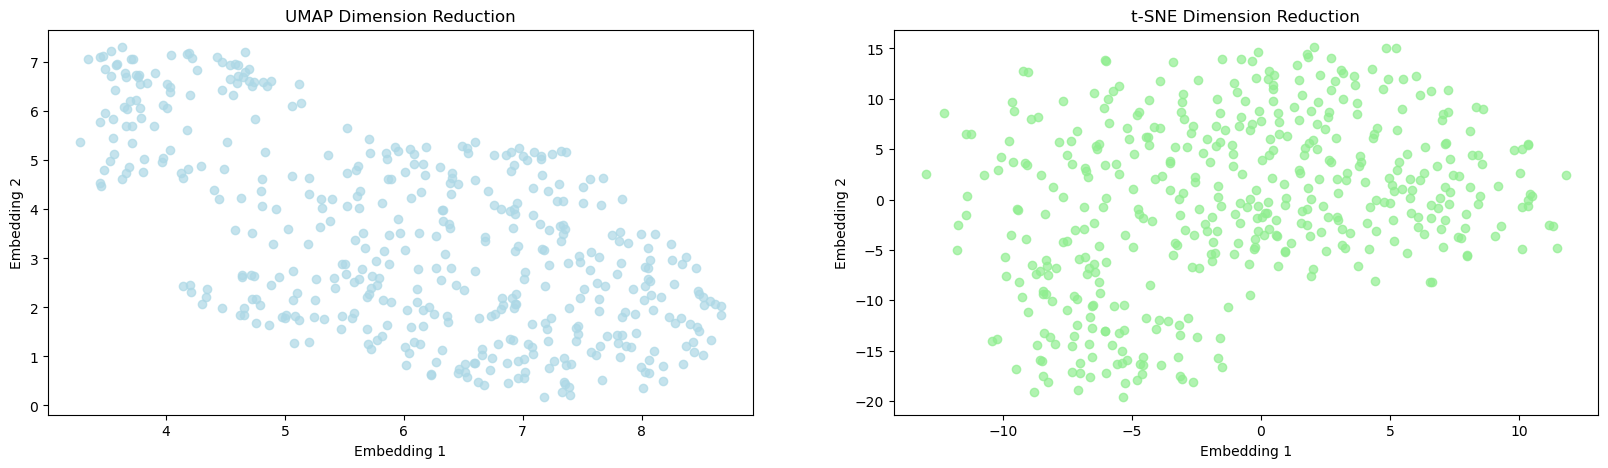

In [4]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].scatter(X_umap[:,0],X_umap[:,1], color='lightblue', alpha=0.7)
ax[0].set_title('UMAP Dimension Reduction')
ax[0].set_xlabel('Embedding 1')
ax[0].set_ylabel('Embedding 2')

ax[1].scatter(X_tsne[:,0],X_tsne[:,1], color='lightgreen', alpha=0.7)
ax[1].set_title('t-SNE Dimension Reduction')
ax[1].set_xlabel('Embedding 1')
ax[1].set_ylabel('Embedding 2')
plt.show()

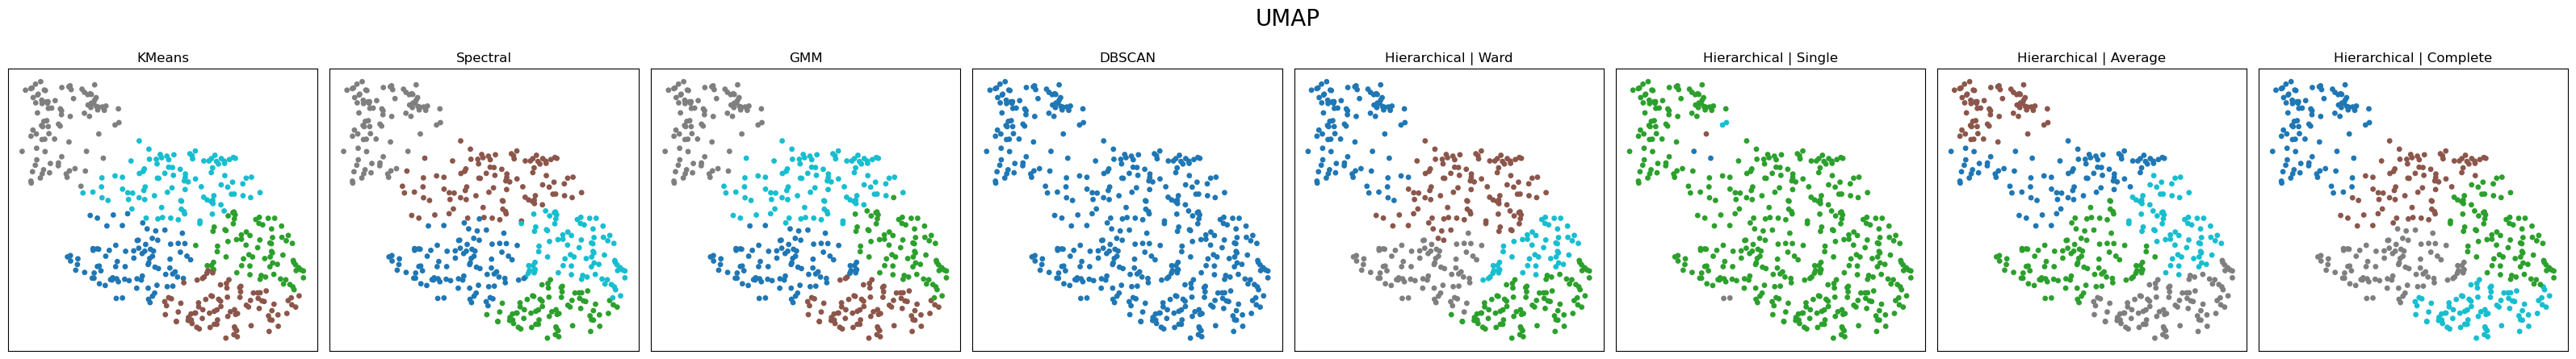

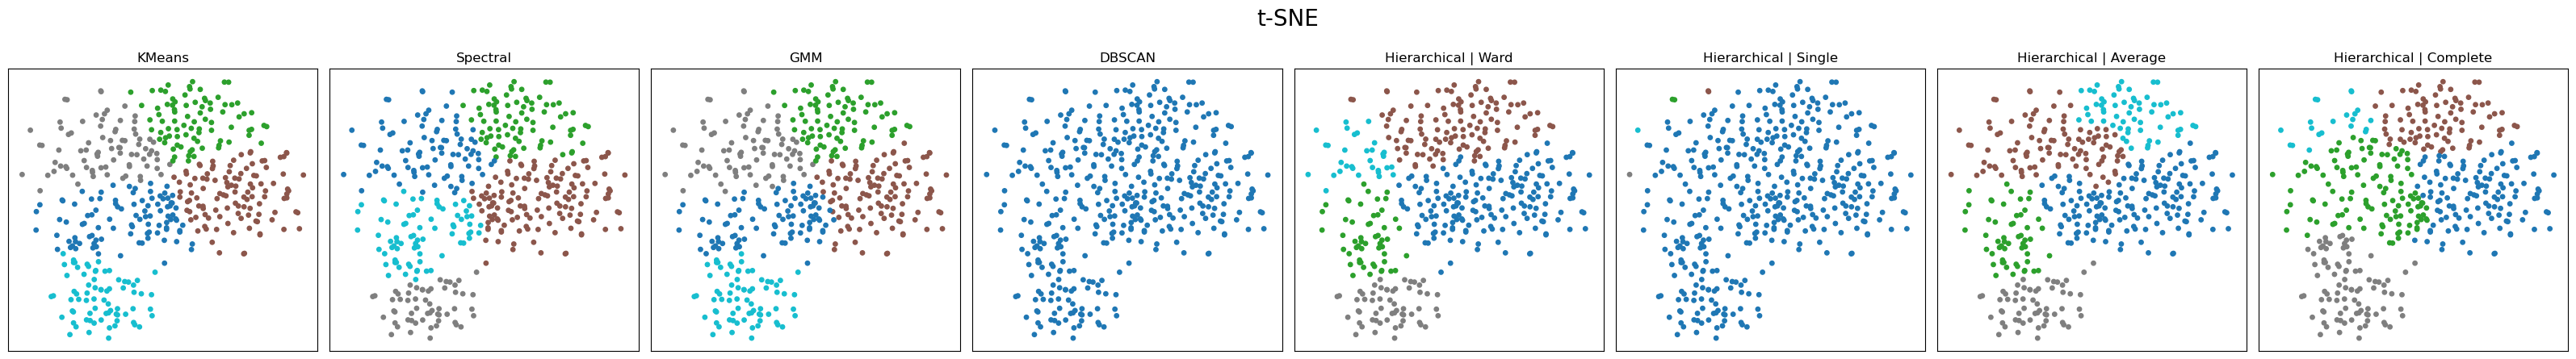

In [5]:
plot_results(*create_cluster_dict(X_umap), title='UMAP')
plot_results(*create_cluster_dict(X_tsne), title='t-SNE')

# Part B

In [6]:
verbose_bool = False

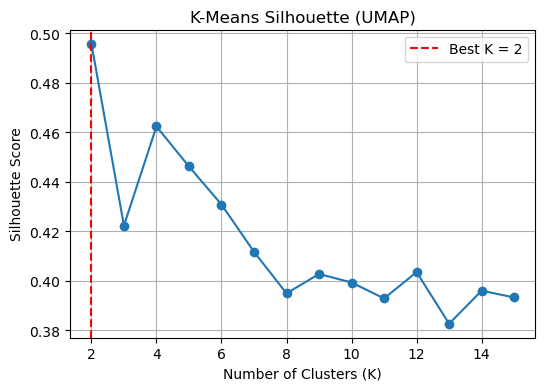

In [7]:
best_k_kmeans, scores_kmeans = silhouette_analysis(
    X_umap,
    method=KMeans,
    params=dict(n_init=10),
    random_state=random_state,
    verbose=verbose_bool
)
plot_silhouette(scores_kmeans, best_k_kmeans, title="K-Means Silhouette (UMAP)")

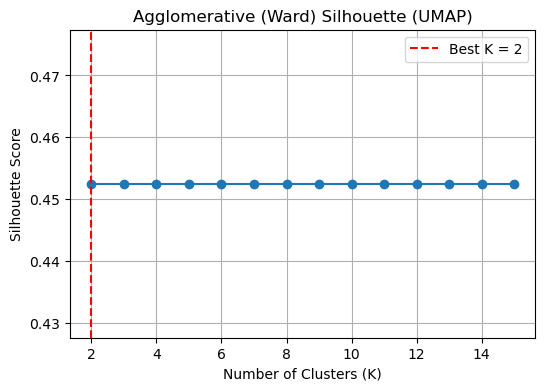

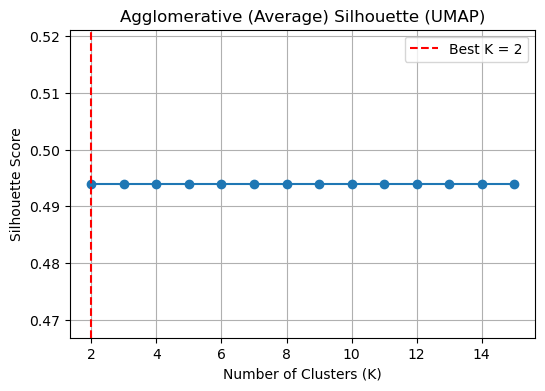

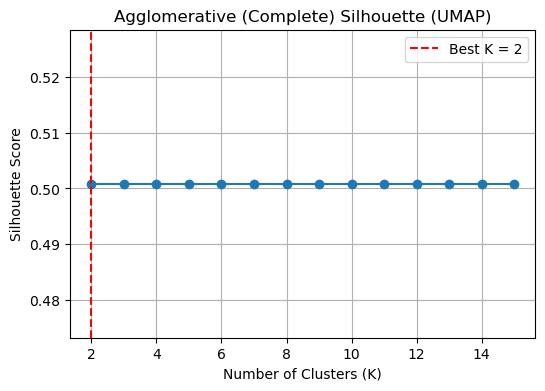

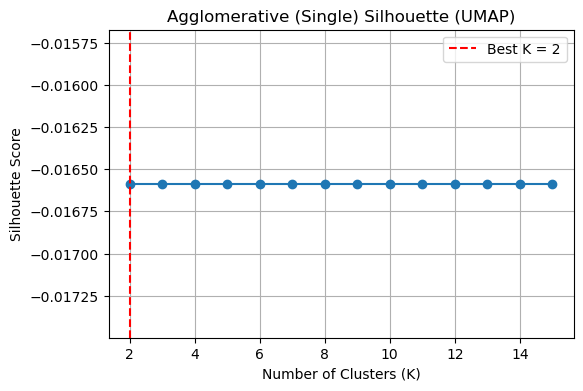

In [8]:
for link in ["ward", "average", "complete", "single"]:
    best_k, scores = (
        silhouette_analysis(
            X_umap, 
            method=AgglomerativeClustering,
            params=dict(linkage=link),
            random_state=random_state,
            verbose=verbose_bool
        )
    )
    plot_silhouette(scores, best_k, title=f"Agglomerative ({link.capitalize()}) Silhouette (UMAP)")

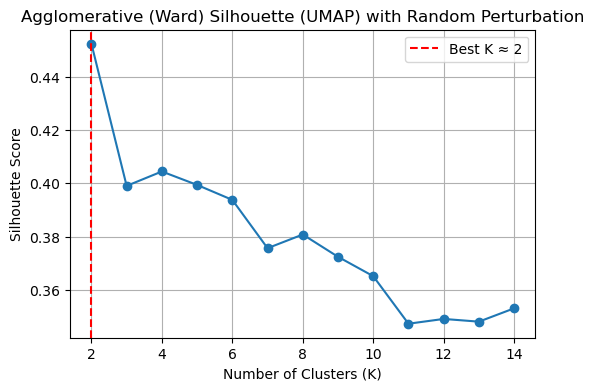

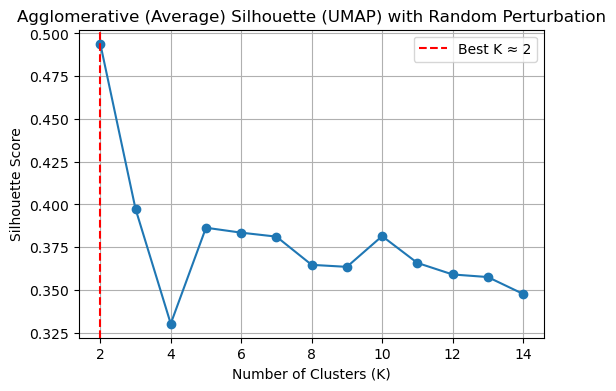

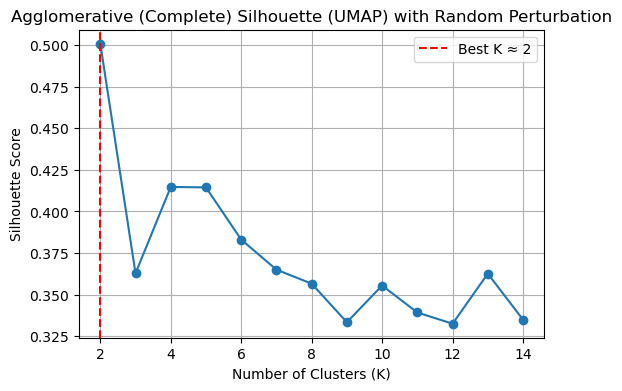

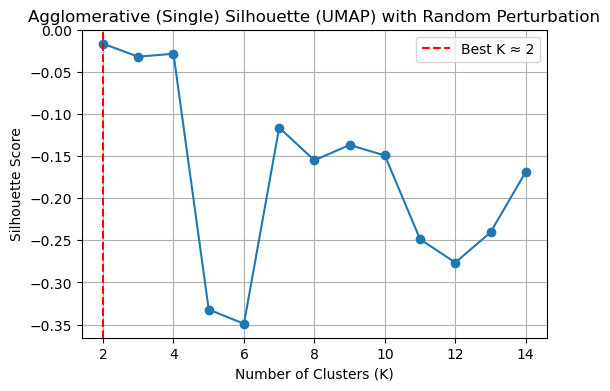

In [9]:
for linkage in ["ward", "average", "complete", "single"]:
    agglomerative_jitter_silhouette_scores(X_umap, random_state, linkage)

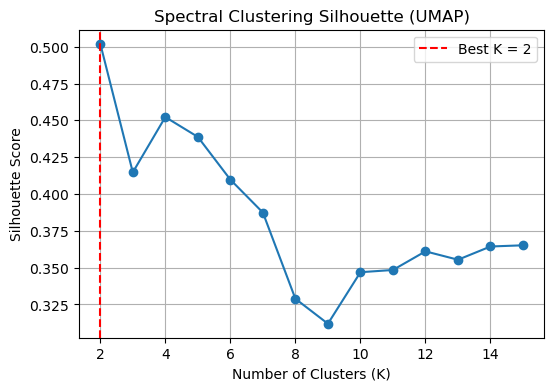

In [10]:
best_k_spec, scores_spec = silhouette_analysis(
    X_umap,
    method=SpectralClustering,
    params=dict(affinity="nearest_neighbors"),
    random_state=random_state,
    verbose=verbose_bool
)
plot_silhouette(
    scores_spec,
    best_k_spec,
    title="Spectral Clustering Silhouette (UMAP)"
)


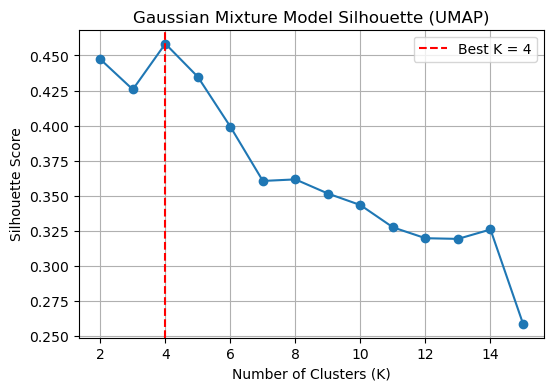

In [ ]:
best_k_gmm, scores_gmm = silhouette_analysis(
    X_umap,
    method=GaussianMixture,
    params=dict(covariance_type="full"),
    random_state=random_state,
    verbose=verbose_bool
)
plot_silhouette(
    scores_gmm,
    best_k_gmm,
    title="Gaussian Mixture Model Silhouette (UMAP)"
)

In [27]:
labels = DBSCAN(eps=0.9, min_samples=5).fit_predict(X)
if len(set(labels)) > 1:
    score = silhouette_score(X, labels)
    print(score)

labels

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

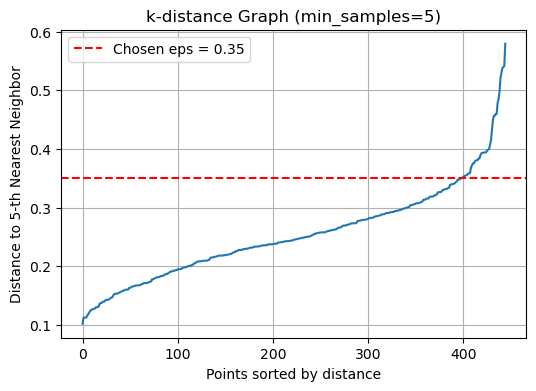

In [35]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Choose min_samples (often 4–6 for 2D, 10–20 for higher dimensions)
min_samples = 5

# Compute distance to the k-th nearest neighbor for every point
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_umap)
distances, indices = neighbors_fit.kneighbors(X_umap)

# Sort the distances (to find the “elbow”)
distances = np.sort(distances[:, -1])  # distance to kth nearest neighbor
plt.figure(figsize=(6,4))
plt.plot(distances)
plt.title(f"k-distance Graph (min_samples={min_samples})")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {min_samples}-th Nearest Neighbor")
plt.grid(True)

eps_opt = 0.35 # Based on the elbow around ~0.35
plt.axhline(eps_opt, color='red', linestyle='--', label=f"Chosen eps = {eps_opt}")
plt.legend()

plt.show()


Silhouette Score: 0.0887


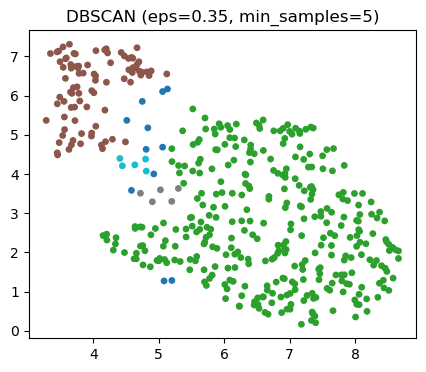

Clusters found: 4
Noise points: 11


In [36]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

model = DBSCAN(eps=eps_opt, min_samples=min_samples)
labels = model.fit_predict(X_umap)

# compute silhouette excluding noise
mask = labels != -1
if len(set(labels[mask])) > 1:
    score = silhouette_score(X_umap[mask], labels[mask])
    print(f"Silhouette Score: {score:.4f}")
else:
    print("Not enough clusters to compute silhouette.")

# visualize
plt.figure(figsize=(5,4))
plt.scatter(X_umap[:,0], X_umap[:,1], c=labels, cmap="tab10", s=15)
plt.title(f"DBSCAN (eps={eps_opt}, min_samples={min_samples})")
plt.show()

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Clusters found: {n_clusters}")
print(f"Noise points: {(labels == -1).sum()}")
